# Affective Signals V (Breathing)
----
<span style="color:Blue">****Through this notebook we hope you get an hands on approach to the seminar. 
    Below you will find code snippets and theory that will help you apply the various libraries that have been introduced to you in the course.**</span>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import collections
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
import collections
import biosignalsnotebooks as bsnb
import subprocess
import heartpy as hp
import seaborn as sns
sns.set()

### Extraction
We will extract the data from the text files that you have recorded during the lab tour. Below you will have code cells which will guide you through the process of extracting the right segment of the signal that you will further use for processing. 

In [ ]:
#path to the data that you recorded
filePath = "./data.txt"

#function provided by biosignals to load data and header
data, header = bsnb.load(filePath, get_header=True)
sampling_rate = header["sampling rate"]

In [ ]:
#information of the dataset
header

In [ ]:
#ECG data 
ECG_raw = data["CH4"]
respiratory_rate = data["CH1"]
time_stamps = bsnb.generate_time(ECG_raw, sampling_rate)

# convert ECG data to mv 
ch = "CH4" # Channel
sr = 1000 # Sampling rate
vcc = 3000 # mV
gain = 1000
resolution = header['resolution'][0] # Resolution (number of available bits)
ECG_mv =  (((np.array(ECG_raw) / 2**resolution) - 0.5) * vcc) / gain

In [ ]:
signal_perc = ((np.array(respiratory_rate) / 2**resolution) - 0.5) * 100
bsnb.plot([time_stamps, time_stamps], [respiratory_rate, signal_perc], y_axis_label=["Raw Data", "Percentage of Full-scale (%)"], grid_lines=1, grid_columns=2, grid_plot=True)

In [ ]:
def load_events(filepath):
    with open(eventFilePath)  as f:
        header = []
        data = []
        for i, line in enumerate(f.readlines()):
            if i < 3:
                if i == 1:
                    header.append(line)
            else:
                data.append(line.strip().split())
    return header, data

In [ ]:
#path to the eventannotation file
eventFilePath = "./eventAnnotation.txt"
header_ev, data_ev = load_events(eventFilePath)
data_ev

Once you are able to load the timestamps you would be able to look at the time in seconds, there should be ideally two timestamps that are your signals that you saved during the recording.

In [ ]:
# update the values of the first timestamp and second timestamp from the values you observed in the event files
first_timestamp = 34.05
second_timestamp = 155.85
total_time = len(ECG_raw)/sampling_rate
first_point = int(sampling_rate*first_timestamp)
second_point = int(sampling_rate*second_timestamp)

In [ ]:
#NormalRR , we use 60s after the first timestamp
timeNormalHr = time_stamps[first_point:first_point+60*sampling_rate]
RespNormalHr = respiratory_rate[first_point:first_point+60*sampling_rate]
ECGNormalHr = ECG_mv[first_point:first_point+60*sampling_rate]
bsnb.plot(timeNormalHr,RespNormalHr)

In [ ]:
#elevatedRR 
timeElevatedHR = time_stamps[second_point:second_point+60*sampling_rate]
RespElevatedHr = respiratory_rate[second_point:second_point+60*sampling_rate]
ecgElevatedHr = ECG_mv[second_point:second_point+60*sampling_rate]
bsnb.plot(timeElevatedHR,RespElevatedHr)

In [ ]:
#starting timestamp for the video with elevated RR
start_video = int(np.round(time_stamps[second_point]- time_stamps[first_point]))

#convert the videos into 1 min snippets 
# pathVideo = "/data/ppg_22_bi_video_stud_lab/raw/P2/video.MOV"
pathVideo = "/home/Notebooks/video.MOV"

subprocess.run(['ffmpeg', '-ss','10','-t','60','-i', pathVideo,  "./"+"NormalHR.mp4"])
subprocess.run(['ffmpeg', '-ss',f'{start_video+10}','-t','60','-i', pathVideo,  "./"+"ElevatedHR.mp4"])

### Theoretical Background



In the last week, you've learned that the healthy heart has an irregular beat-to-beat rhythm. This rhythm variability reflects the interplay of the autonomic nervous system: During inhalation of air into the lungs the sympathicus has a higher impact on the heart due to inhibition of the [vagotonia](https://en.wikipedia.org/wiki/Vagotonia). Hence, the heart rate synchronizes with the respiratory cycle, meaning it increases with inspiration and decreases with expiration. It is called respiratory sinus arrhythmia ([RSA](https://pubmed.ncbi.nlm.nih.gov/14769752/)) and can be well seen during sleep and in young children.

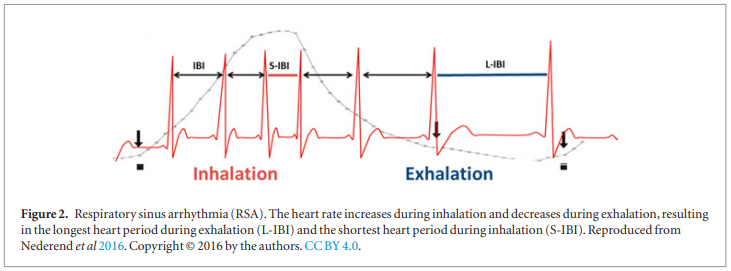

Respiration rate extraction is categorized into three modalities: extraction from physiological signals (ECG, PPG,...), based on respiratory movements (upper body), based on airflow (thermal camera).




### Deep Learning method to extract the HR and RR([MTTS-CAN](https://arxiv.org/pdf/2006.03790.pdf))

In [ ]:
import numpy as np
import cv2
from skimage.util import img_as_float
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import scipy.io
from scipy.sparse import spdiags

def preprocess_raw_video(videoFilePath, dim=36):

    #########################################################################
    # set up
    t = []
    i = 0
    vidObj = cv2.VideoCapture(videoFilePath);
    totalFrames = int(vidObj.get(cv2.CAP_PROP_FRAME_COUNT)) # get total frame size
    print("Total Number of frames", totalFrames)
    Xsub = np.zeros((totalFrames, dim, dim, 3), dtype = np.float32)
    height = vidObj.get(cv2.CAP_PROP_FRAME_HEIGHT)
    width = vidObj.get(cv2.CAP_PROP_FRAME_WIDTH)
    success, img = vidObj.read()
    dims = img.shape
    print("Orignal Height", height)
    print("Original width", width)
    #########################################################################
    # Crop each frame size into dim x dim
    while success:
        t.append(vidObj.get(cv2.CAP_PROP_POS_MSEC))# current timestamp in milisecond
        vidLxL = cv2.resize(img_as_float(img[:, int(width/2)-int(height/2 + 1):int(height/2)+int(width/2), :]), (dim, dim), interpolation = cv2.INTER_AREA)
#         vidLxL = cv2.rotate(vidLxL, cv2.ROTATE_90_CLOCKWISE) # rotate 90 degree
        vidLxL = cv2.cvtColor(vidLxL.astype('float32'), cv2.COLOR_BGR2RGB)
        vidLxL[vidLxL > 1] = 1
        vidLxL[vidLxL < (1/255)] = 1/255
        Xsub[i, :, :, :] = vidLxL
        success, img = vidObj.read() # read the next one
        i = i + 1
    plt.imshow(Xsub[0])
    plt.title('Sample Preprocessed Frame')
    plt.show()
    #########################################################################
    # Normalized Frames in the motion branch
    normalized_len = len(t) - 1
    dXsub = np.zeros((normalized_len, dim, dim, 3), dtype = np.float32)
    for j in range(normalized_len - 1):
        dXsub[j, :, :, :] = (Xsub[j+1, :, :, :] - Xsub[j, :, :, :]) / (Xsub[j+1, :, :, :] + Xsub[j, :, :, :])
    dXsub = dXsub / np.std(dXsub)
    #########################################################################
    # Normalize raw frames in the apperance branch
    Xsub = Xsub - np.mean(Xsub)
    Xsub = Xsub  / np.std(Xsub)
    Xsub = Xsub[:totalFrames-1, :, :, :]
    #########################################################################
    # Plot an example of data after preprocess
#     print(dXsub.shape,Xsub.shape)
    dXsub = np.concatenate((dXsub, Xsub), axis = 3);
    return dXsub

def detrend(signal, Lambda):
    """detrend(signal, Lambda) -> filtered_signal
    This function applies a detrending filter.
    This code is based on the following article "An advanced detrending method with application
    to HRV analysis". Tarvainen et al., IEEE Trans on Biomedical Engineering, 2002.
    *Parameters*
      ``signal`` (1d numpy array):
        The signal where you want to remove the trend.
      ``Lambda`` (int):
        The smoothing parameter.
    *Returns*
      ``filtered_signal`` (1d numpy array):
        The detrended signal.
    """
    signal_length = signal.shape[0]

    # observation matrix
    H = np.identity(signal_length)

    # second-order difference matrix

    ones = np.ones(signal_length)
    minus_twos = -2 * np.ones(signal_length)
    diags_data = np.array([ones, minus_twos, ones])
    diags_index = np.array([0, 1, 2])
    D = spdiags(diags_data, diags_index, (signal_length - 2), signal_length).toarray()
    filtered_signal = np.dot((H - np.linalg.inv(H + (Lambda ** 2) * np.dot(D.T, D))), signal)
    return filtered_signal


In [ ]:
import tensorflow as tf
import numpy as np
import scipy.io
import os
import sys
import argparse
sys.path.append('../')
from model import Attention_mask, MTTS_CAN
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter
# from inference_preprocess import preprocess_raw_video, detrend

def predict_vitals(video_path, sampling_rate=25, batch_size=100 ):
    img_rows = 36
    img_cols = 36
    frame_depth = 10
    model_checkpoint = './mtts_can.hdf5'
    batch_size = batch_size
    fs = sampling_rate
    sample_data_path = video_path

    dXsub = preprocess_raw_video(sample_data_path, dim=36)
    print('dXsub shape', dXsub.shape)

    dXsub_len = (dXsub.shape[0] // frame_depth)  * frame_depth
    dXsub = dXsub[:dXsub_len, :, :, :]

    model = MTTS_CAN(frame_depth, 32, 64, (img_rows, img_cols, 3))
    model.load_weights(model_checkpoint)

    yptest = model.predict((dXsub[:, :, :, :3], dXsub[:, :, :, -3:]), batch_size=batch_size, verbose=1)

    pulse_pred = yptest[0]
    pulse_pred = detrend(np.cumsum(pulse_pred), 100)
    [b_pulse, a_pulse] = butter(1, [0.75 / fs * 2, 2.5 / fs * 2], btype='bandpass')
    pulse_pred = scipy.signal.filtfilt(b_pulse, a_pulse, np.double(pulse_pred))

    resp_pred = yptest[1]
    resp_pred = detrend(np.cumsum(resp_pred), 100)
    [b_resp, a_resp] = butter(1, [0.08 / fs * 2, 0.5 / fs * 2], btype='bandpass')
    resp_pred = scipy.signal.filtfilt(b_resp, a_resp, np.double(resp_pred))

    ########## Plot ##################
    plt.subplot(211)
    plt.plot(pulse_pred)
    plt.title('Pulse Prediction')
    plt.subplot(212)
    plt.plot(resp_pred)
    plt.title('Resp Prediction')
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.6)
    plt.show()
    
    
    return pulse_pred, resp_pred


In [ ]:
#prediction of respiratory rate for both elevated and normal RR
#Adjust the sampling rate accordingly
fps = 25

pulse_pred_NR, resp_pred_NR = predict_vitals("./NormalHR.mp4", sampling_rate=fps)
pulse_pred_EL, resp_pred_EL = predict_vitals("./ElevatedHR.mp4", sampling_rate=fps)

In [ ]:
#Normal rate
RespNormalHr_rs = scipy.signal.resample(RespNormalHr, resp_pred_NR.shape[0])
normalized_NR = (RespNormalHr_rs-min(RespNormalHr_rs))/(max(RespNormalHr_rs)-min(RespNormalHr_rs))
resp_pred_NR = (resp_pred_NR-min(resp_pred_NR))/(max(resp_pred_NR)-min(resp_pred_NR))
plt.plot(normalized_NR, label="Ground Truth")
plt.plot(resp_pred_NR, label="Predicted")
plt.xlabel("frames")
plt.ylabel("Normalized BVP")
plt.legend()

In [ ]:
#Elevated rate
#since Jan's elevated HR video was 56.1 seconds long, we would have to crop the ground truth signal accordingly
#before we resample it.If you Elevated RR is also 1 min long you dont have have to make this change

crop_index = int(56.1*sampling_rate) #time*1000
RespElevatedHr_rs = scipy.signal.resample(RespElevatedHr[:crop_index], resp_pred_EL.shape[0])

# RespElevatedHr_rs = scipy.signal.resample(RespElevatedHr, resp_pred_EL.shape[0])
normalized_EL = (RespElevatedHr_rs-min(RespElevatedHr_rs))/(max(RespElevatedHr_rs)-min(RespElevatedHr_rs))
resp_pred_EL = (resp_pred_EL-min(resp_pred_EL))/(max(resp_pred_EL)-min(resp_pred_EL))
plt.plot(normalized_EL, label="Ground Truth")
plt.plot(resp_pred_EL, label="Predicted")
plt.xlabel("frames")
plt.ylabel("Normalized BVP")
plt.legend()

In [ ]:
import numpy as np
from scipy.signal import welch
from scipy.signal import find_peaks, stft
from plotly.subplots import make_subplots
from plotly.colors import n_colors
import plotly.graph_objects as go
from scipy.interpolate import interp1d
from pyVHR.plot.visualize import VisualizeParams
from pyVHR.BPM.utils import *
from scipy.stats import median_absolute_deviation as mad

"""
This module contains all the class and the methods for transforming 
a BVP signal in a BPM signal.
"""

class RPsignal:
    """
    Manage (multi-channel, row-wise) BVP signals, and transforms them in BPMs.
    """
    #nFFT = 2048  # freq. resolution for STFTs
    step = 1       # step in seconds

    def __init__(self, data, fs, startTime=0, minHz=0.75, maxHz=4., verb=False):
        if len(data.shape) == 1:
            self.data = data.reshape(1, -1)  # 2D array raw-wise
        else:
            self.data = data
        self.fs = fs                       # sample rate
        self.startTime = startTime
        self.verb = verb
        self.minHz = minHz
        self.maxHz = maxHz
        nyquistF = self.fs/2
        fRes = 0.5
        self.nFFT = max(2048, (60*2*nyquistF) / fRes)

    def spectrogram(self, winsize=5):
        """
        Compute the BVP signal spectrogram restricted to the
        band 42-240 BPM by using winsize (in sec) samples.
        """

        # -- spect. Z is 3-dim: Z[#chnls, #freqs, #times]
        F, T, Z = stft(self.data,
                       self.fs,
                       nperseg=self.fs*winsize,
                       noverlap=self.fs*(winsize-self.step),
                       boundary='even',
                       nfft=self.nFFT)
        Z = np.squeeze(Z, axis=0)

        # -- freq subband (0.75 Hz - 4.0 Hz)
        minHz = 0.08
        maxHz = 1
        band = np.argwhere((F > minHz) & (F < maxHz)).flatten()
        self.spect = np.abs(Z[band, :])     # spectrum magnitude
        self.freqs = 60*F[band]            # spectrum freq in bpm
        self.times = T                     # spectrum times

        # -- BPM estimate by spectrum
        self.bpm = self.freqs[np.argmax(self.spect, axis=0)]

    def getRPM(self, winsize=5):
        """
        Get the BPM signal extracted from the ground truth BVP signal.
        """
        self.spectrogram(winsize)
        return self.bpm, self.times

#### Task 5.1 Have a look at your Respiratory rate over time and use what you learned in the lecture to see if they make sense. what are the differences you observer between Also talk about what are the specific things that you would expect to see between the two videos w.r.t the change in breathing rate. 

Your observations go here:

#### Normal Respiration: RPM estimation

In [ ]:
#Ground Truth RPM
rpsignal = RPsignal(normalized_NR,fps)
rpm_NR, timerpm_NR = rpsignal.getRPM(winsize = 20)
#Predicted RPM
rpsignal_MTTS = RPsignal(resp_pred_NR,fps)
rpm_pred_NR, timerpm_pred_NR = rpsignal_MTTS.getRPM(winsize = 20)

#### Elevated Respiration: RPM estimation

In [ ]:
#Ground Truth RPM
rpsignal = RPsignal(normalized_EL,fps)
rpm_EL, timerpm_EL = rpsignal.getRPM(winsize = 20)
#Predicted RPM
rpsignal_MTTS = RPsignal(resp_pred_EL,fps)
rpm_pred_EL, timerpm_pred_EL = rpsignal_MTTS.getRPM(winsize = 20)

#### Task 5.2 Use the evaluation metrics( MAE and RMSE) to evaluate the predictions. Document the results and discuss them.

In [ ]:
###############################
#     your code goes here     #
###############################

# you can use built in funcitons or write your own funtions to calculate the MAE and RMSE.


#### Task 5.3 Plot the ground truth signals (ECG and Respiratory rate) and see if you can find some relationship between them.(consider both the elevated and normal part of the signal)

In [ ]:
###############################
#     your code goes here     #
###############################




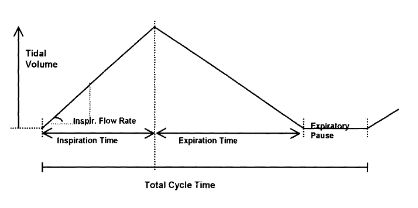
[source](https://lernraumplus.uni-bielefeld.de/pluginfile.php/745448/mod_resource/content/1/10_MBP_breathing_processing_V2.pdf)

From the above figure you can see how inspiration and expiration time is calculated.Inspiration time  is the time from the tidal volume takes to reach a peak from the minima and expiration time is the the time taken from the peak to the minima.

#### Task 5.4 Calculate the average duration of inspiration and expiration. Also calculate the ratio between them. 
Hint: [find peaks](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html?highlight=find%20peaks#scipy.signal.find_peaks)

In [ ]:
###############################
#     your code goes here     #
###############################

#Find the peaks and minimas to calculate the inspiration and expiration time. 



#### Task 5.5 In the previous task you  calculated the inspiration and expiration time. Using knowledge from the lecture, do the findings match your expectations? If they don't discuss why the calculations might not be precise.

Your analysis:

#### Task 5.6 Below you will find figures for how the HR(BPM) and RR(RPM and Raw signal) varied, Look if both signals might have a relationship in their behavior. Look for parts where they support your knowledge of heart rate and breathing activity.

In [ ]:
from pyVHR.utils.ecg import ECGsignal
#Normal HR
signal_NR = ECGsignal(ECGNormalHr, 1000)
bpmGT_NR_GT, timeGT_NR_GT = signal_NR.getBPM(winsize=20)

#Normal Respiration
rsignal_NR = RPsignal(RespNormalHr,1000)
rpm_NR_GT, timerpm_NR_GT = rsignal_NR.getRPM(winsize = 20)

#Elevated Respiration
rpsignal_EL = RPsignal(RespElevatedHr,1000)
rpm_EL_GT, timerpm_EL_GT = rpsignal_EL.getRPM(winsize = 20)

#Elevated HR
signal_EL = ECGsignal(ecgElevatedHr, 1000)
bpmGT_EL_GT, timeGT_EL_GT= signal_EL.getBPM(winsize=20)


fig, ax = plt.subplots(3,2,figsize=(30,20))
ax[0][0].plot(timerpm_NR_GT,rpm_NR_GT)
ax[0][0].set_ylabel("RPM")
ax[0][0].set_xlabel("Time(s)")

ax[1][0].plot(timeGT_NR_GT,bpmGT_NR_GT,label="BPM")
ax[1][0].set_ylabel("BPM")
ax[1][0].set_xlabel("Time(s)")

ax[2][0].plot(np.arange(0,len(timeNormalHr)),RespNormalHr, label="Respiratory signal")
ax[2][0].set_ylabel("Raw value")
ax[2][0].set_xlabel("Samples(1000/s)")

ax[0][0].set_title("Normal HR/RR")


# fig, ax = plt.subplots(2)
ax[0][1].plot(timerpm_EL_GT,rpm_EL_GT)
ax[0][1].set_ylabel("RPM")
ax[0][1].set_xlabel("Time(s)")

ax[1][1].plot(timeGT_EL_GT,bpmGT_EL_GT)
ax[1][1].set_ylabel("BPM")
ax[1][1].set_xlabel("Time(s)")

ax[2][1].plot(np.arange(0,len(timeElevatedHR)),RespElevatedHr, label="Respiratory signal")
ax[2][1].set_ylabel("Raw value")
ax[2][1].set_xlabel("Samples(1000/s)")

ax[0][1].set_title("Elevated HR/RR")


Your observations go here:

#### Bonus Task: You can get an extra point to compensate for previous errors/late submission/missing points of previous notebooks :)
#### Bonus Task 5.7 Create a Bland-Altman plot for the predicted and ground truth RR. (more info about [bland-altman plot](https://en.wikipedia.org/wiki/Bland%E2%80%93Altman_plot))

In [ ]:
###############################
#     your code goes here     #
###############################

